In [1]:
# Load in libraries and plot parameters
import pandas as pd
import numpy as np
import os
from scipy import fftpack, signal, interpolate
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize, LogNorm
from matplotlib.cm import ScalarMappable
import sys
sys.path.append('./py-nbs')

# Importing functions from gw_utils and noise_curves
from utilsgw import (
    compute_fft, compute_asd, butterworth_filter, model_list, resample_signal, taper_signal,
    plot_waveforms, make_combined_plot, style_plot, 
    calculate_snr_waveform, calculate_partial_snr, plot_sensitivity_curves
)
from noise_curves import (
    Asharp, LIGO_O3b_1262178304, AdVirgo, LIGO_O3_H1, 
    LIGO_O3_L1, ALIGO_O4, CE, ET, LGWAnb, LGWAsi, GLOCc, GLOCo, 
    DECIGO, BDECIGO, LILA, ALIA, DO, TianGO, BBO, atom
)

# Matplotlib parameters
plt.rcParams.update({
    "figure.figsize": (41, 24),
    "font.size": 66,
    "xtick.direction": 'in',
    "ytick.direction": 'in',
    "xtick.top": True,
    "ytick.right": True,
    "pgf.texsystem": 'pdflatex',
    "pgf.rcfonts": False,
    "axes.linewidth": 4,
    "xtick.major.size": 12,
    "xtick.major.width": 4,
    "xtick.minor.size": 10,
    "xtick.minor.width": 3,
    "ytick.major.size": 12,
    "ytick.major.width": 4,
    "ytick.minor.size": 10,
    "ytick.minor.width": 3
})

In [2]:
import os
import numpy as np
from scipy.fft import fft, fftfreq, fftshift

# Manually set the base directory if __file__ is not defined
base_dir = os.getcwd()
matter_data_dir = os.path.join(base_dir, 'Data', 'Models', 'Matter')

# Model names
models = ['9a', '9b', '9.25', '9.5', '11', '12.25', '14', '15.01', '16', '17', '18', '18.5', '19', '19.56', '20', '21.68', '23', '24', '25', '40', '60']

# Initialize lists and dictionaries for data storage
input_models_matter = {}
tapered_models_matter = {}
all_f_original_matter = []  # Ensure these are lists
all_abs_H_original_matter = []
all_f_final_matter = []
all_abs_H_final_matter = []
final_models_matter = {}

# Desired waveform length after tapering
final_length = 10  # seconds

# Processing models
for model in models:
    try:
        file_path = os.path.join(matter_data_dir, f'{model}/{model}_strains_x.txt')
        if not os.path.exists(file_path):
            print(f"File for model {model} does not exist at path: {file_path}")
            continue  # Skip to the next iteration if the file doesn't exist
        
        # Load time and strain data
        time, hp, hc = np.loadtxt(file_path, usecols=(0, 1, 2), unpack=True)
        print(f"Data loaded successfully for model {model}")
        
        # Time shift so it starts at zero
        tA = time - time[0]
        hA = hp  # Using strain h+
        np.savetxt(f"Data/Models/Matter/{model}_matter_original_data.txt", np.column_stack((tA, hA)), delimiter="\t", header="tA\thA", comments='')
        
        # Resample the signal to LVK sampling rate
        fs = 16384  # Hz
        t_resampled, h_resampled = resample_signal(tA, hA, fs)
        np.savetxt(f"Data/Models/Matter/{model}_matter_resampled_data.txt", np.column_stack((t_resampled, h_resampled)), delimiter="\t", header="t\th", comments='')

        # Calculate current signal length in seconds
        current_length = t_resampled[-1] - t_resampled[0]

        # Calculate T_tail based on the difference between current length and 10 seconds
        T_tail = final_length - current_length
        if T_tail < 0:
            print(f"Model {model} has a waveform longer than {final_length} seconds. Trimming will be applied.")
            T_tail = 0  # If the waveform is already longer than 10 seconds, set T_tail to 0 (no tail extension)

        # Apply taper to the signal (tail length is set to make the total length 10 seconds)
        t_tapered, h_tapered = taper_signal(t_resampled, h_resampled, fs, T_tail=T_tail)
        np.savetxt(f"Data/Models/Matter/{model}_matter_processed_data.txt", np.column_stack((t_tapered, h_tapered)), delimiter="\t", header="t\th", comments='')

        # Ensure the final waveform is 10 seconds long
        if len(t_tapered) < final_length * fs:
            # If the waveform is shorter than 10 seconds, pad with zeros
            padding_length = int(final_length * fs - len(t_tapered))
            t_padded = np.linspace(0, final_length, final_length * fs)
            h_padded = np.pad(h_tapered, (0, padding_length), 'constant')
        else:
            # If longer, trim to exactly 10 seconds
            t_padded = t_tapered[:final_length * fs]
            h_padded = h_tapered[:final_length * fs]

        # Save the tapered and adjusted waveform data
        tapered_models_matter[model] = {'time': t_padded, 'strain': h_padded}

        # Compute FFT and PSD for original and tapered signals
        f_original, PSD_original = compute_fft(t_resampled, h_resampled)
        f_tapered, PSD_tapered = compute_fft(t_padded, h_padded)
        f_original, PSD_original = compute_asd(t_resampled, h_resampled)
        f_tapered, PSD_tapered = compute_asd(t_padded, h_padded)        
        
        
        # Save the original and processed waveforms to dictionaries
        input_models_matter[model] = {'time': t_resampled, 'strain': h_resampled, 'freq': f_original, 'psd': PSD_original}
        final_models_matter[model] = {'time': t_padded, 'strain': h_padded, 'freq': f_tapered, 'psd': PSD_tapered}

        # Append frequency and amplitude data for each model
        all_f_original_matter.append(f_original)
        all_abs_H_original_matter.append(PSD_original)
        all_f_final_matter.append(f_tapered)
        all_abs_H_final_matter.append(PSD_tapered)

    except Exception as e:
        print(f"Error processing model {model}: {e}")


Data loaded successfully for model 9a
Data loaded successfully for model 9b
Data loaded successfully for model 9.25
Data loaded successfully for model 9.5
Data loaded successfully for model 11
Data loaded successfully for model 12.25
Data loaded successfully for model 14
Data loaded successfully for model 15.01
Data loaded successfully for model 16
Data loaded successfully for model 17
Data loaded successfully for model 18
Data loaded successfully for model 18.5
Data loaded successfully for model 19
Data loaded successfully for model 19.56
Data loaded successfully for model 20
Data loaded successfully for model 21.68
Data loaded successfully for model 23
Data loaded successfully for model 24
Data loaded successfully for model 25
Data loaded successfully for model 40
Data loaded successfully for model 60


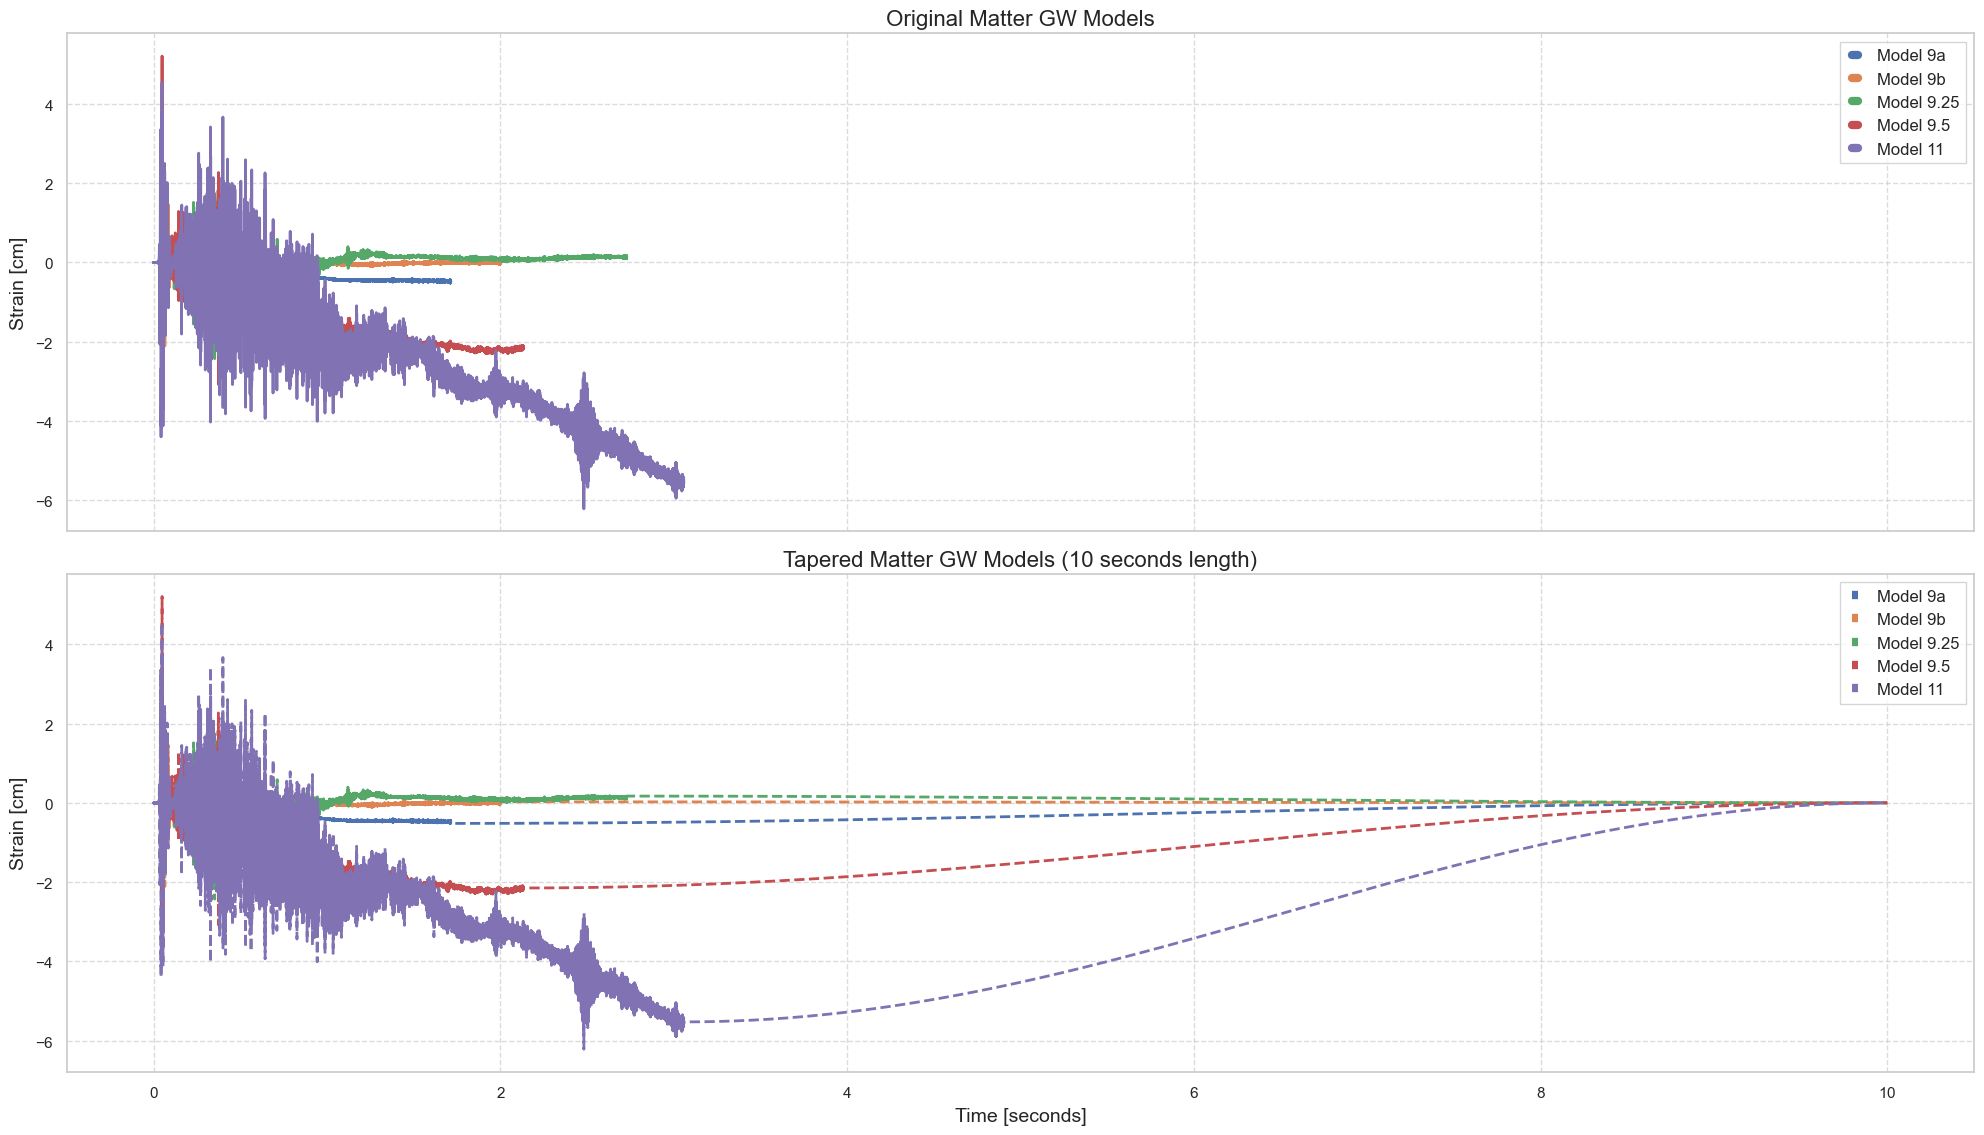

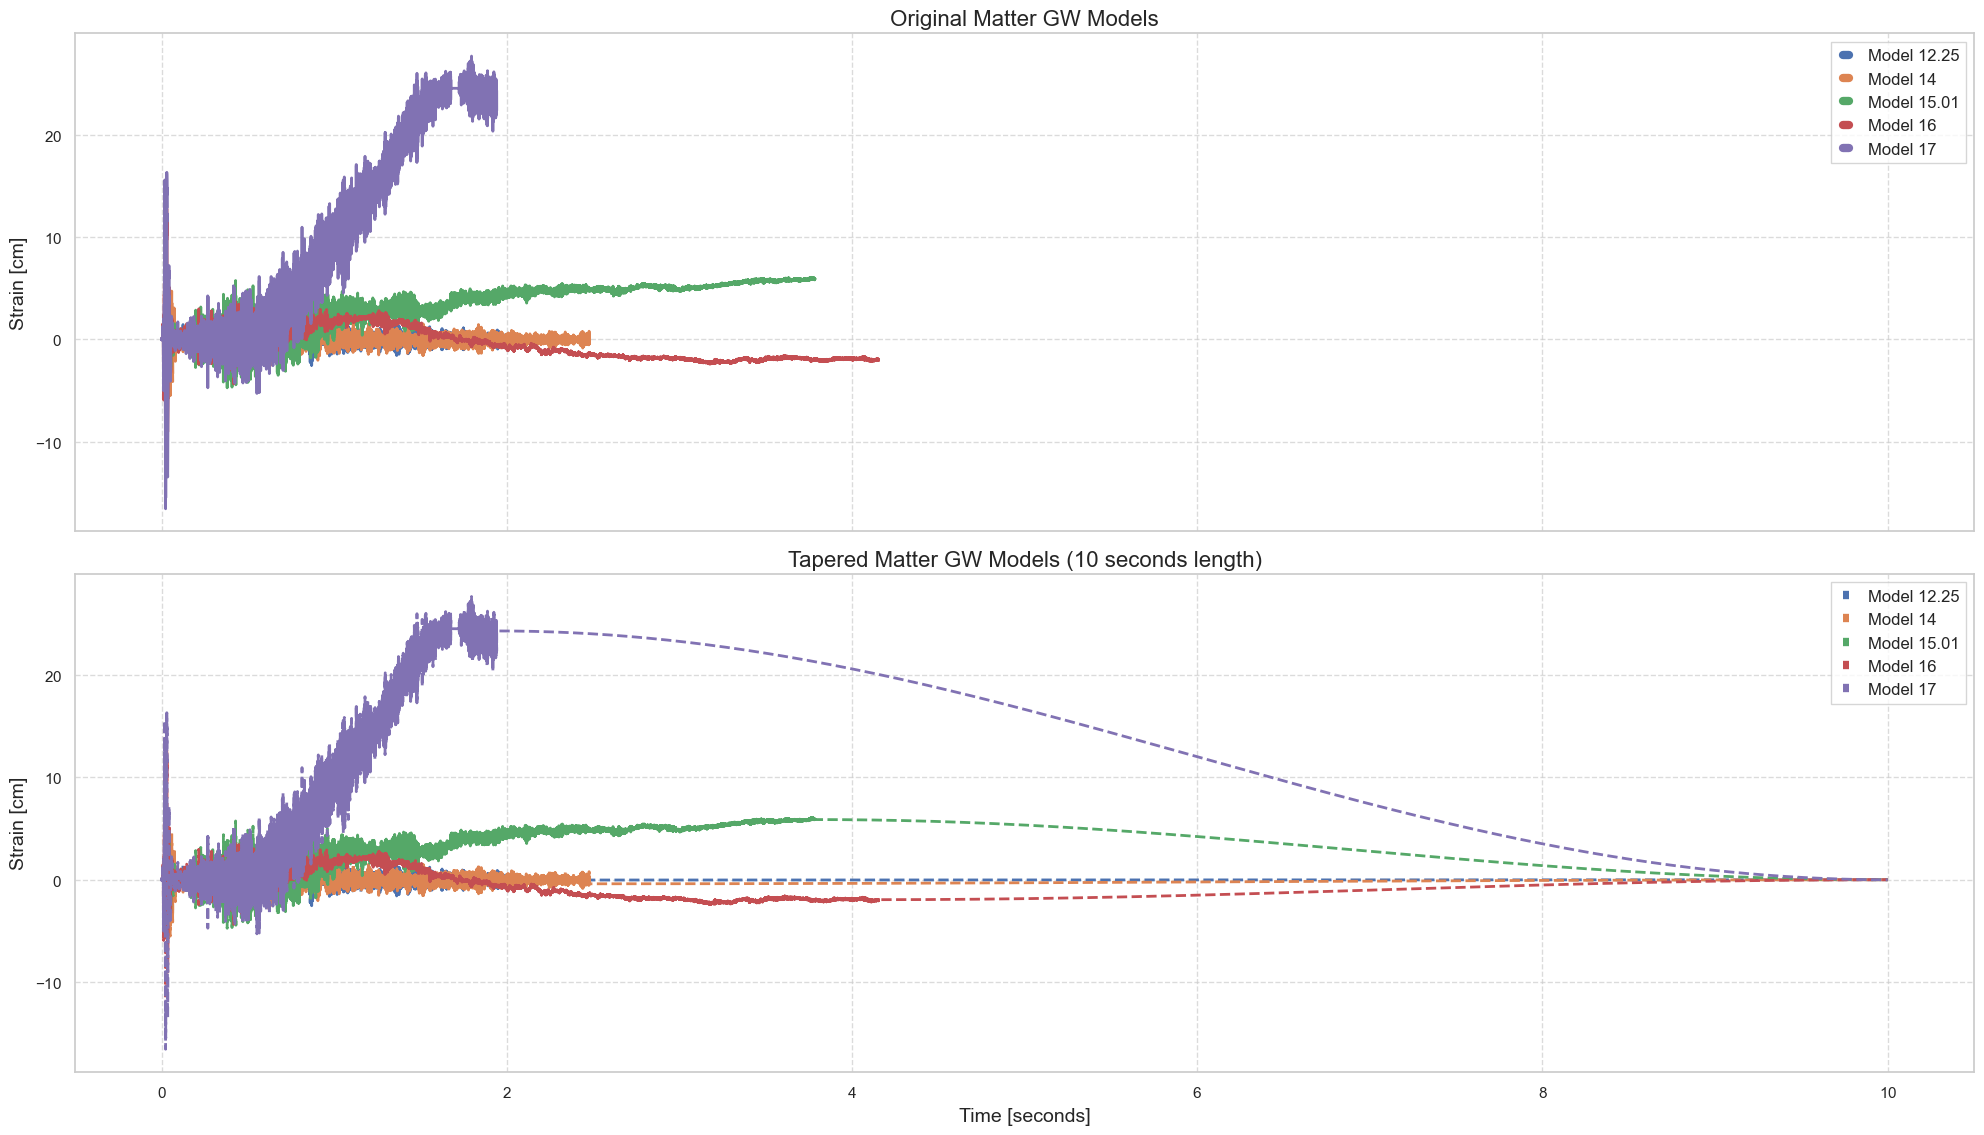

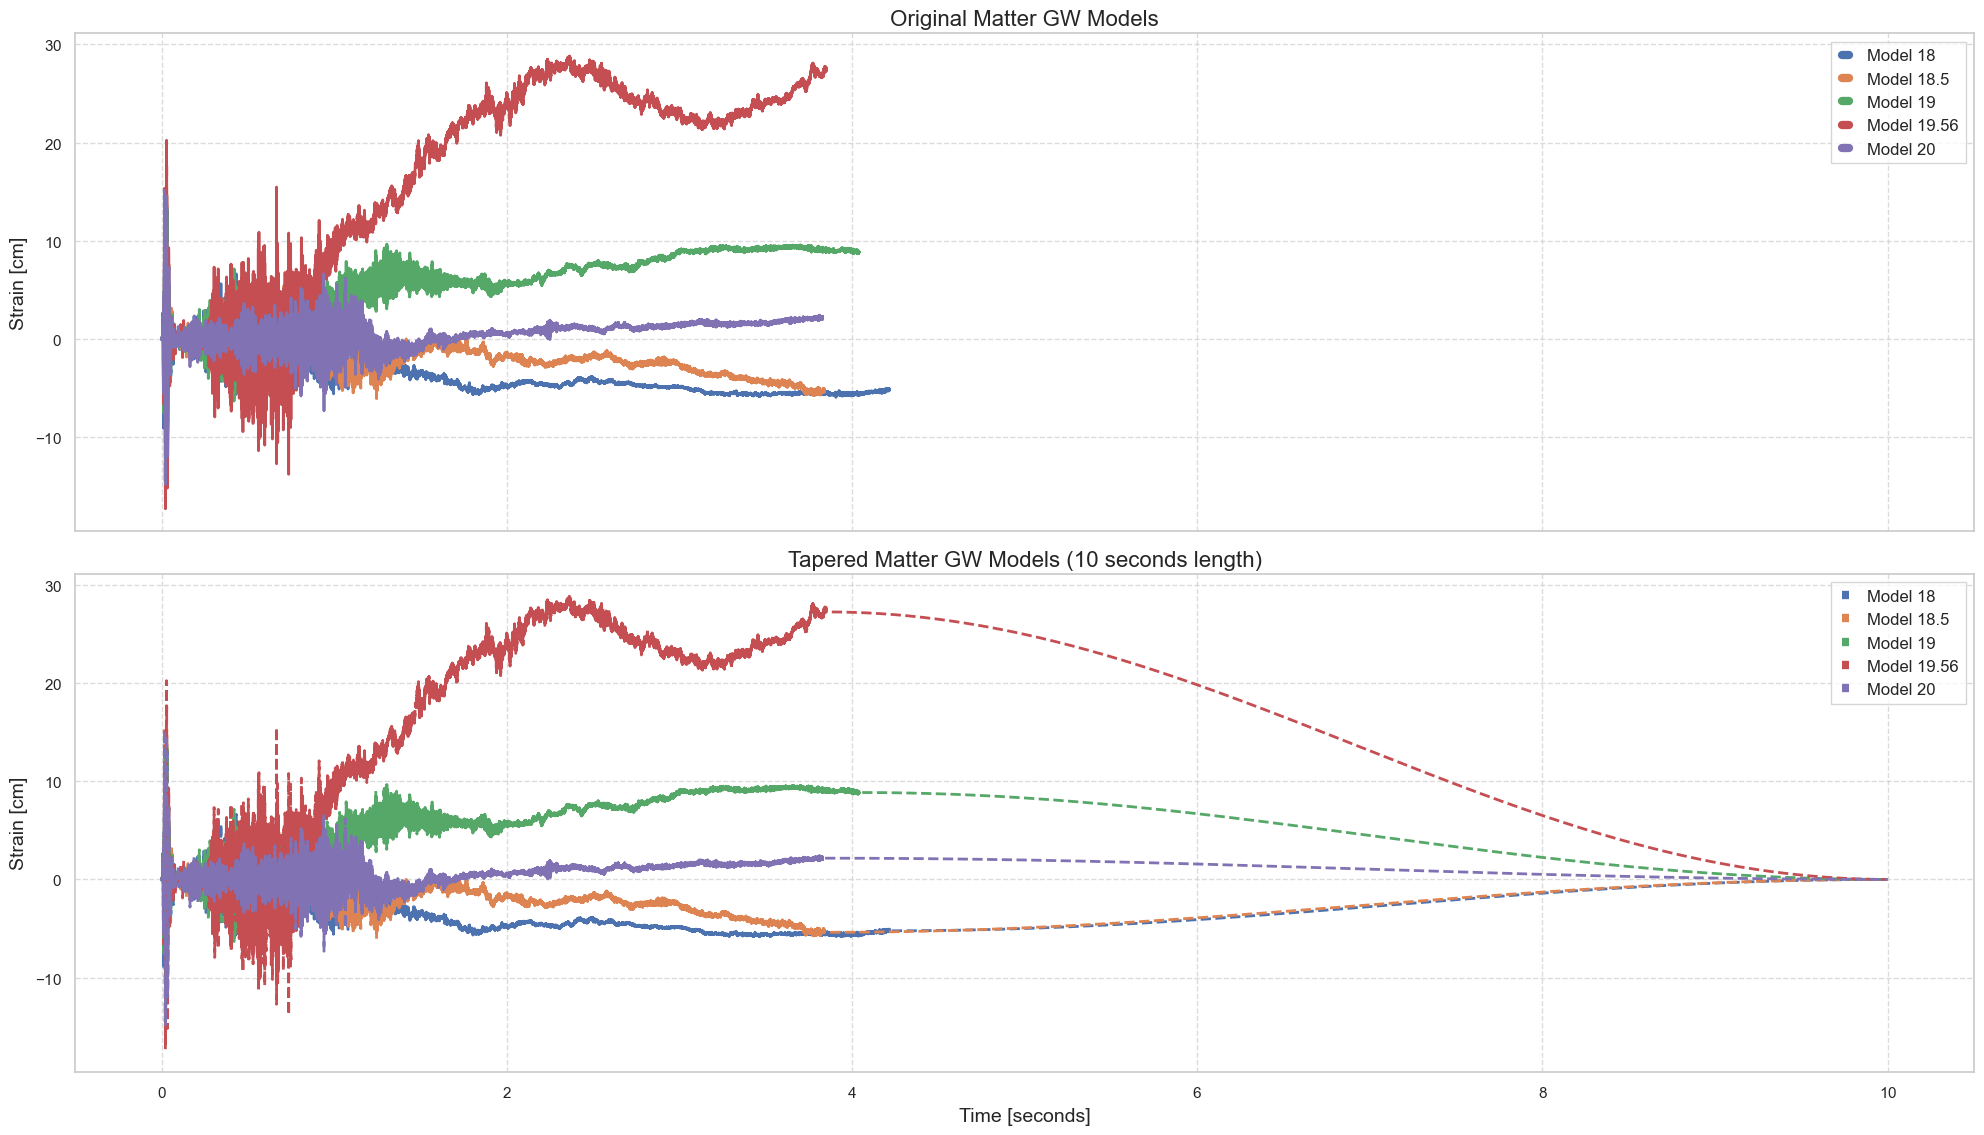

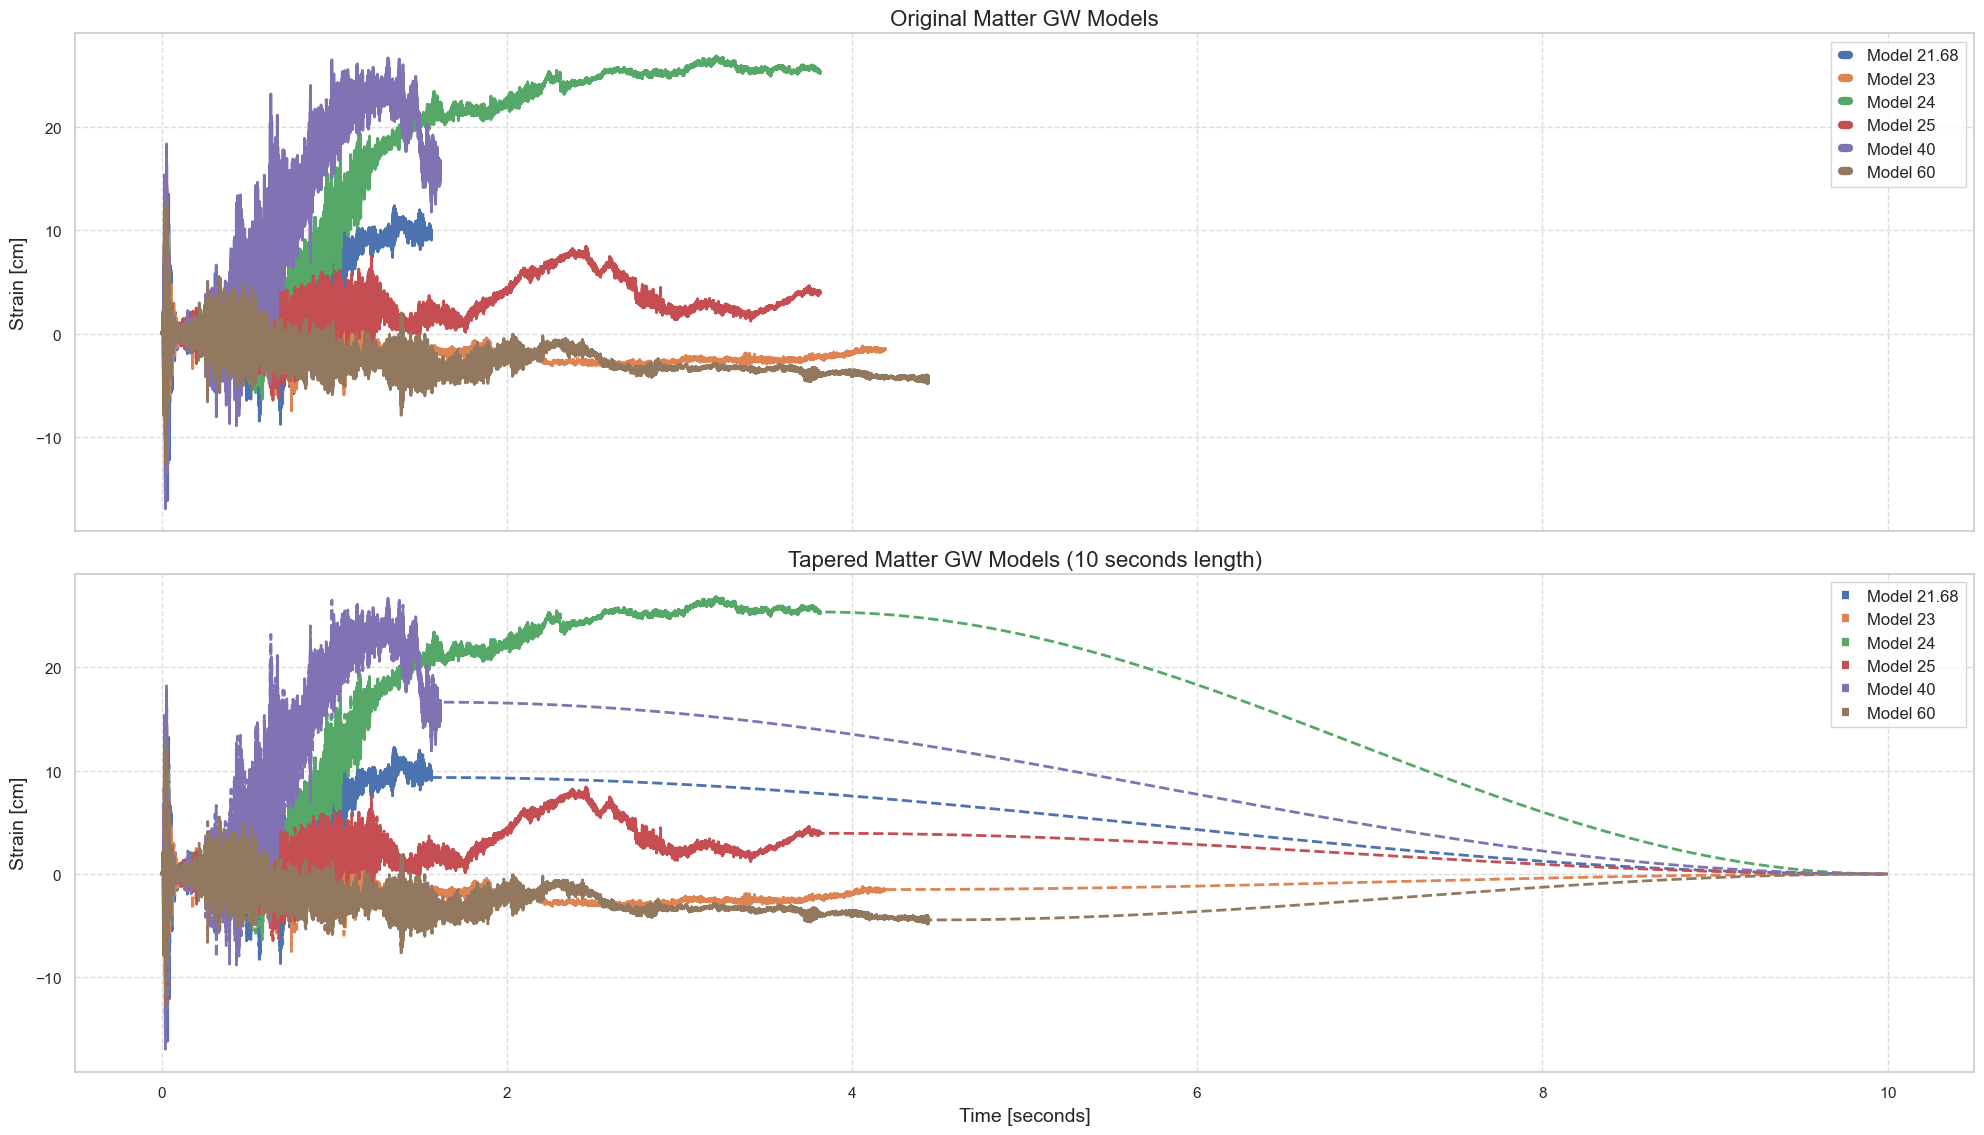

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Define model groups
model_groups = [
    ['9a', '9b', '9.25', '9.5', '11'],
    ['12.25', '14', '15.01', '16', '17'],
    ['18', '18.5', '19', '19.56', '20'],
    ['21.68', '23', '24', '25', '40', '60']
]

# Plot each group of models
for models in model_groups:
    fig, ax = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    
    # Track plotted models to avoid duplication
    plotted_models = set()
    
    for model in models:
        # Ensure that each model is only plotted once
        if model not in plotted_models:
            try:
                original_data = input_models_matter[model]
                tapered_data = tapered_models_matter[model]

                # Plot original waveforms
                ax[0].plot(original_data['time'], original_data['strain'], label=f'Model {model}', linestyle='-', linewidth=2)

                # Plot tapered waveforms
                ax[1].plot(tapered_data['time'], tapered_data['strain'], label=f'Model {model}', linestyle='--', linewidth=2)

                # Mark this model as plotted
                plotted_models.add(model)
            except KeyError:
                print(f"Data for model {model} not found in dictionaries.")
                continue

    # Customize original waveform plot
    ax[0].set_ylabel('Strain [cm]', fontsize=14)
    ax[0].set_title('Original Matter GW Models', fontsize=16)
    ax[0].grid(True, linestyle='--', alpha=0.7)
    ax[0].legend(loc="upper right", fontsize=12)

    # Customize tapered waveform plot
    ax[1].set_xlabel('Time [seconds]', fontsize=14)
    ax[1].set_ylabel('Strain [cm]', fontsize=14)
    ax[1].set_title('Tapered Matter GW Models (10 seconds length)', fontsize=16)
    ax[1].grid(True, linestyle='--', alpha=0.7)
    ax[1].legend(loc="upper right", fontsize=12)

    # Adjust layout to prevent overlap
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    plt.show()


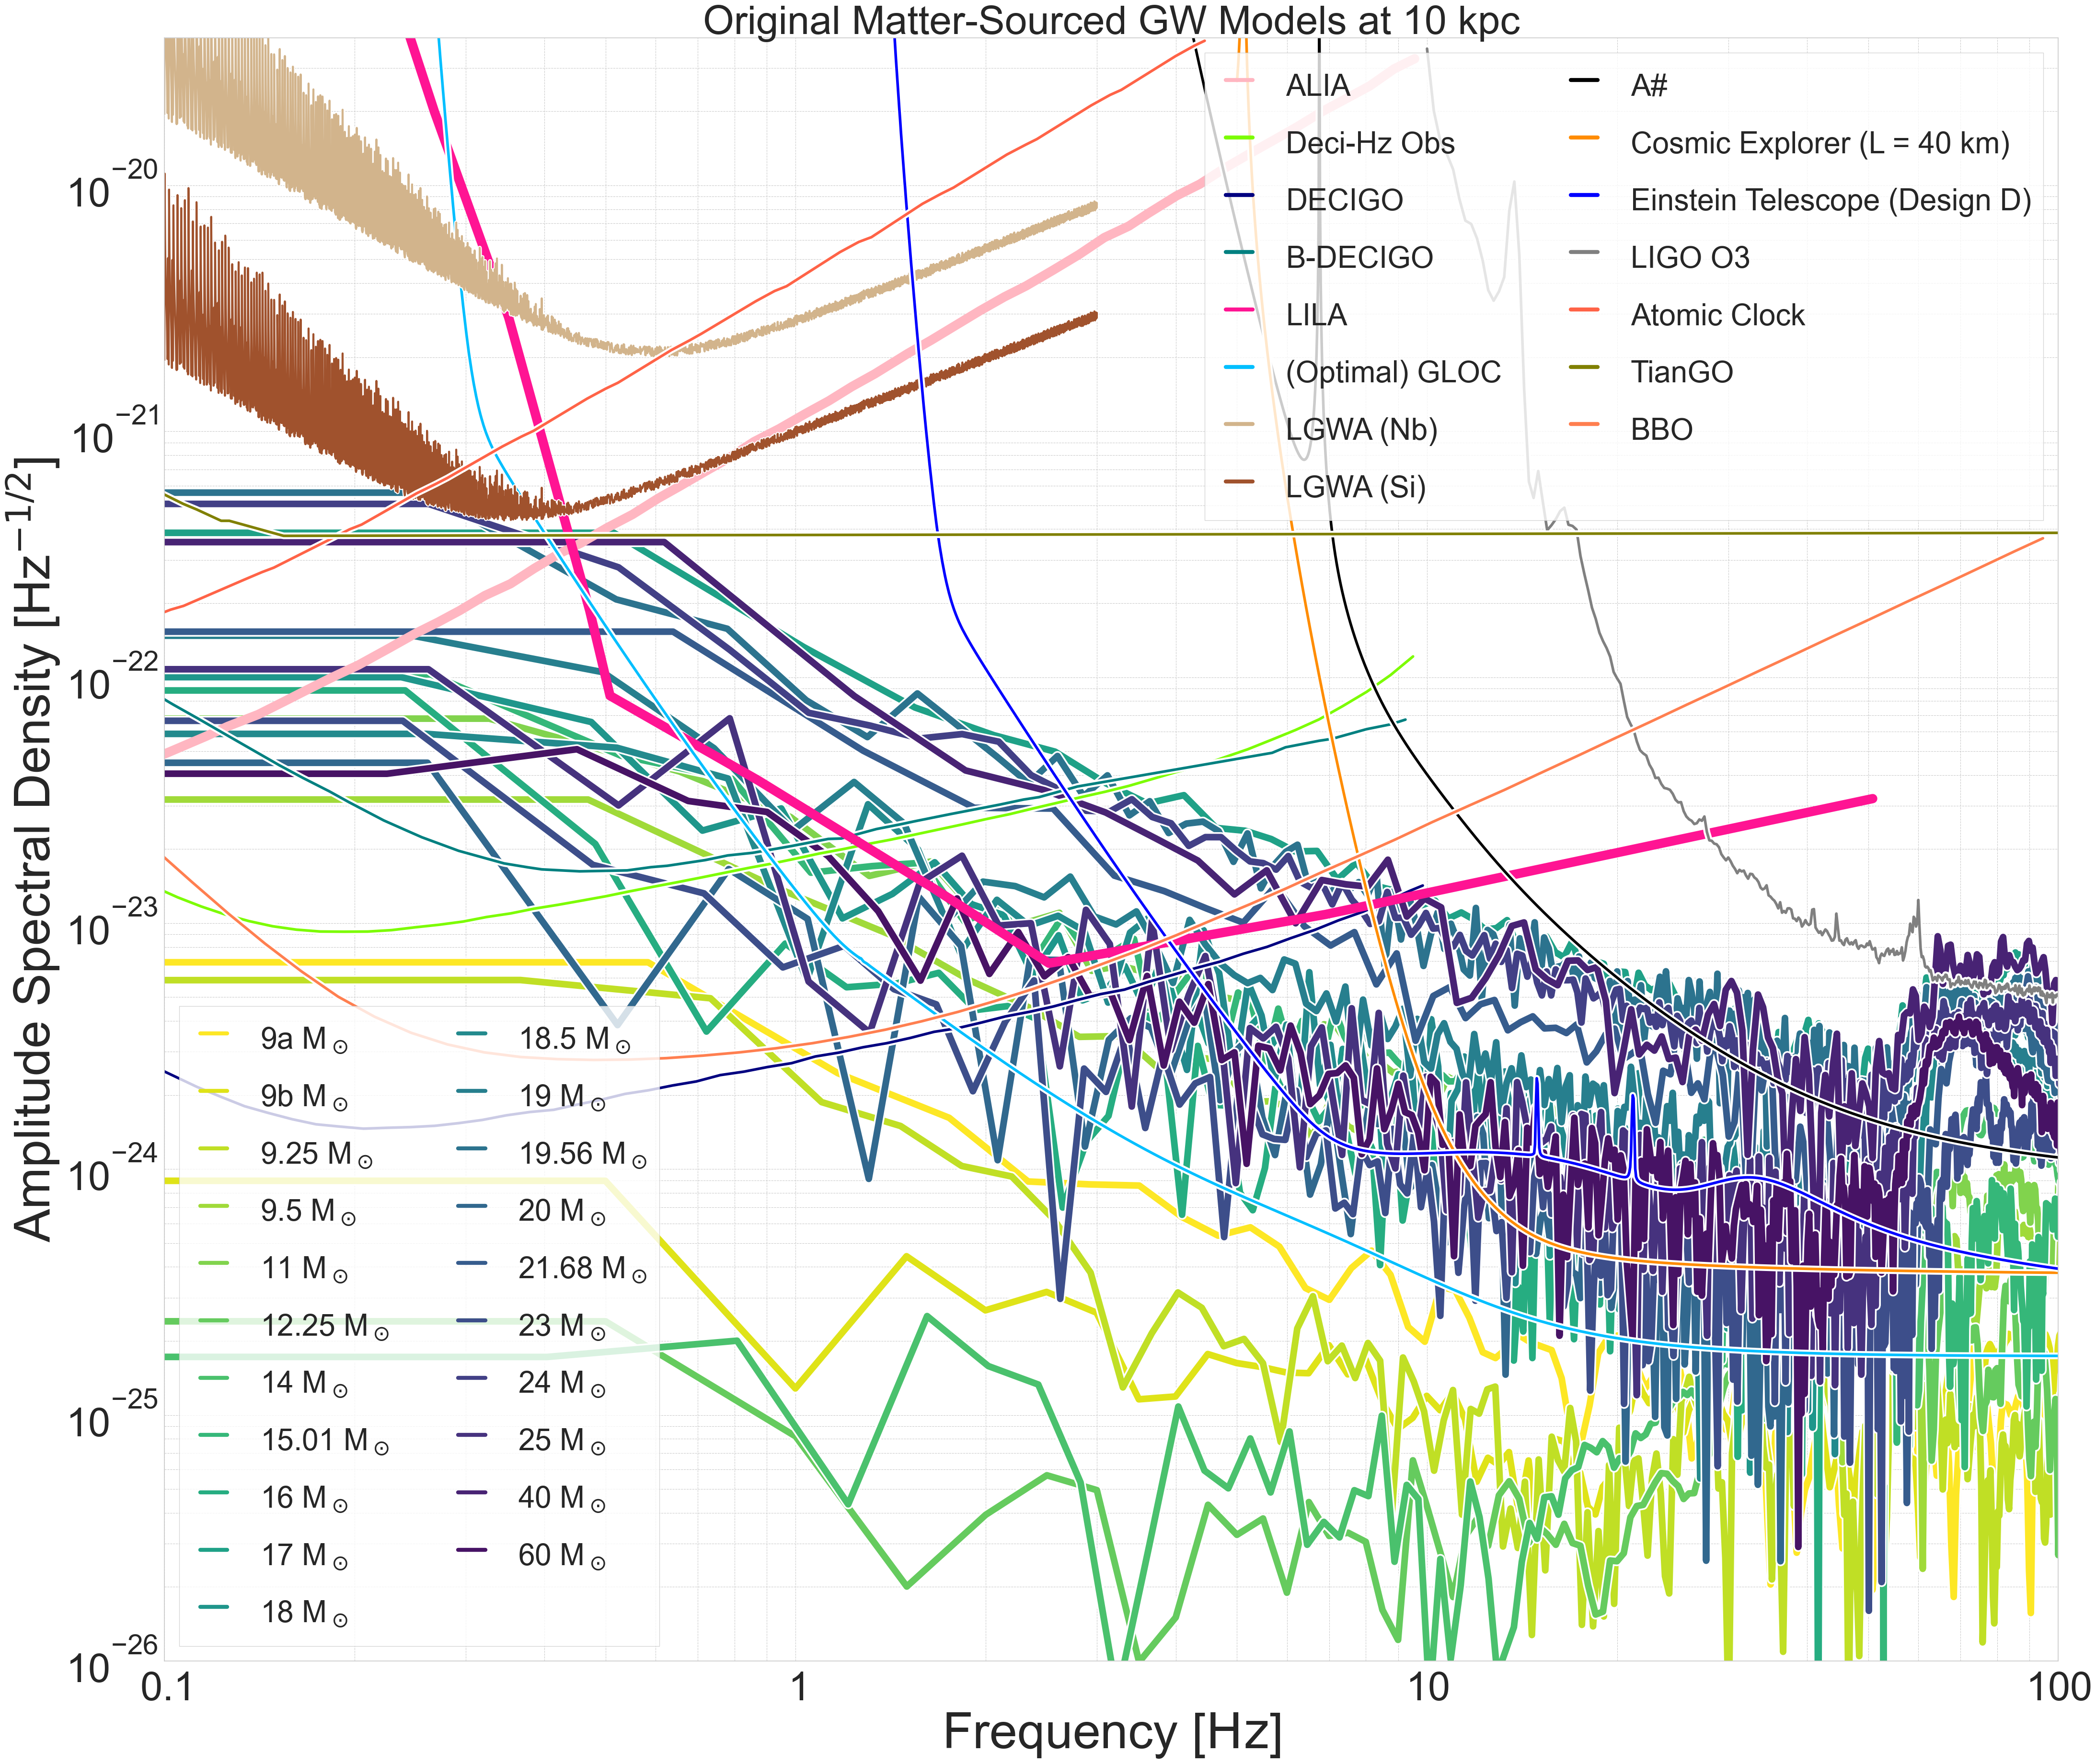

In [4]:
models = ['9a', '9b', '9.25', '9.5', '11', '12.25', '14', '15.01', '16', '17', '18', '18.5', '19', '19.56', '20', '21.68', '23', '24', '25', '40', '60']
fig, ax = plt.subplots(figsize=(51, 44))
final_curves = plot_waveforms(models,*model_list(input_models_matter,var1='freq', var2='psd'), ax, cmap=plt.cm.viridis_r)
sensitivity_curves = plot_sensitivity_curves(ax)
style_plot(ax, legends = [sensitivity_curves, final_curves])
ax.set_title('Original Matter-Sourced GW Models at 10 kpc', fontsize=60)
plt.show()

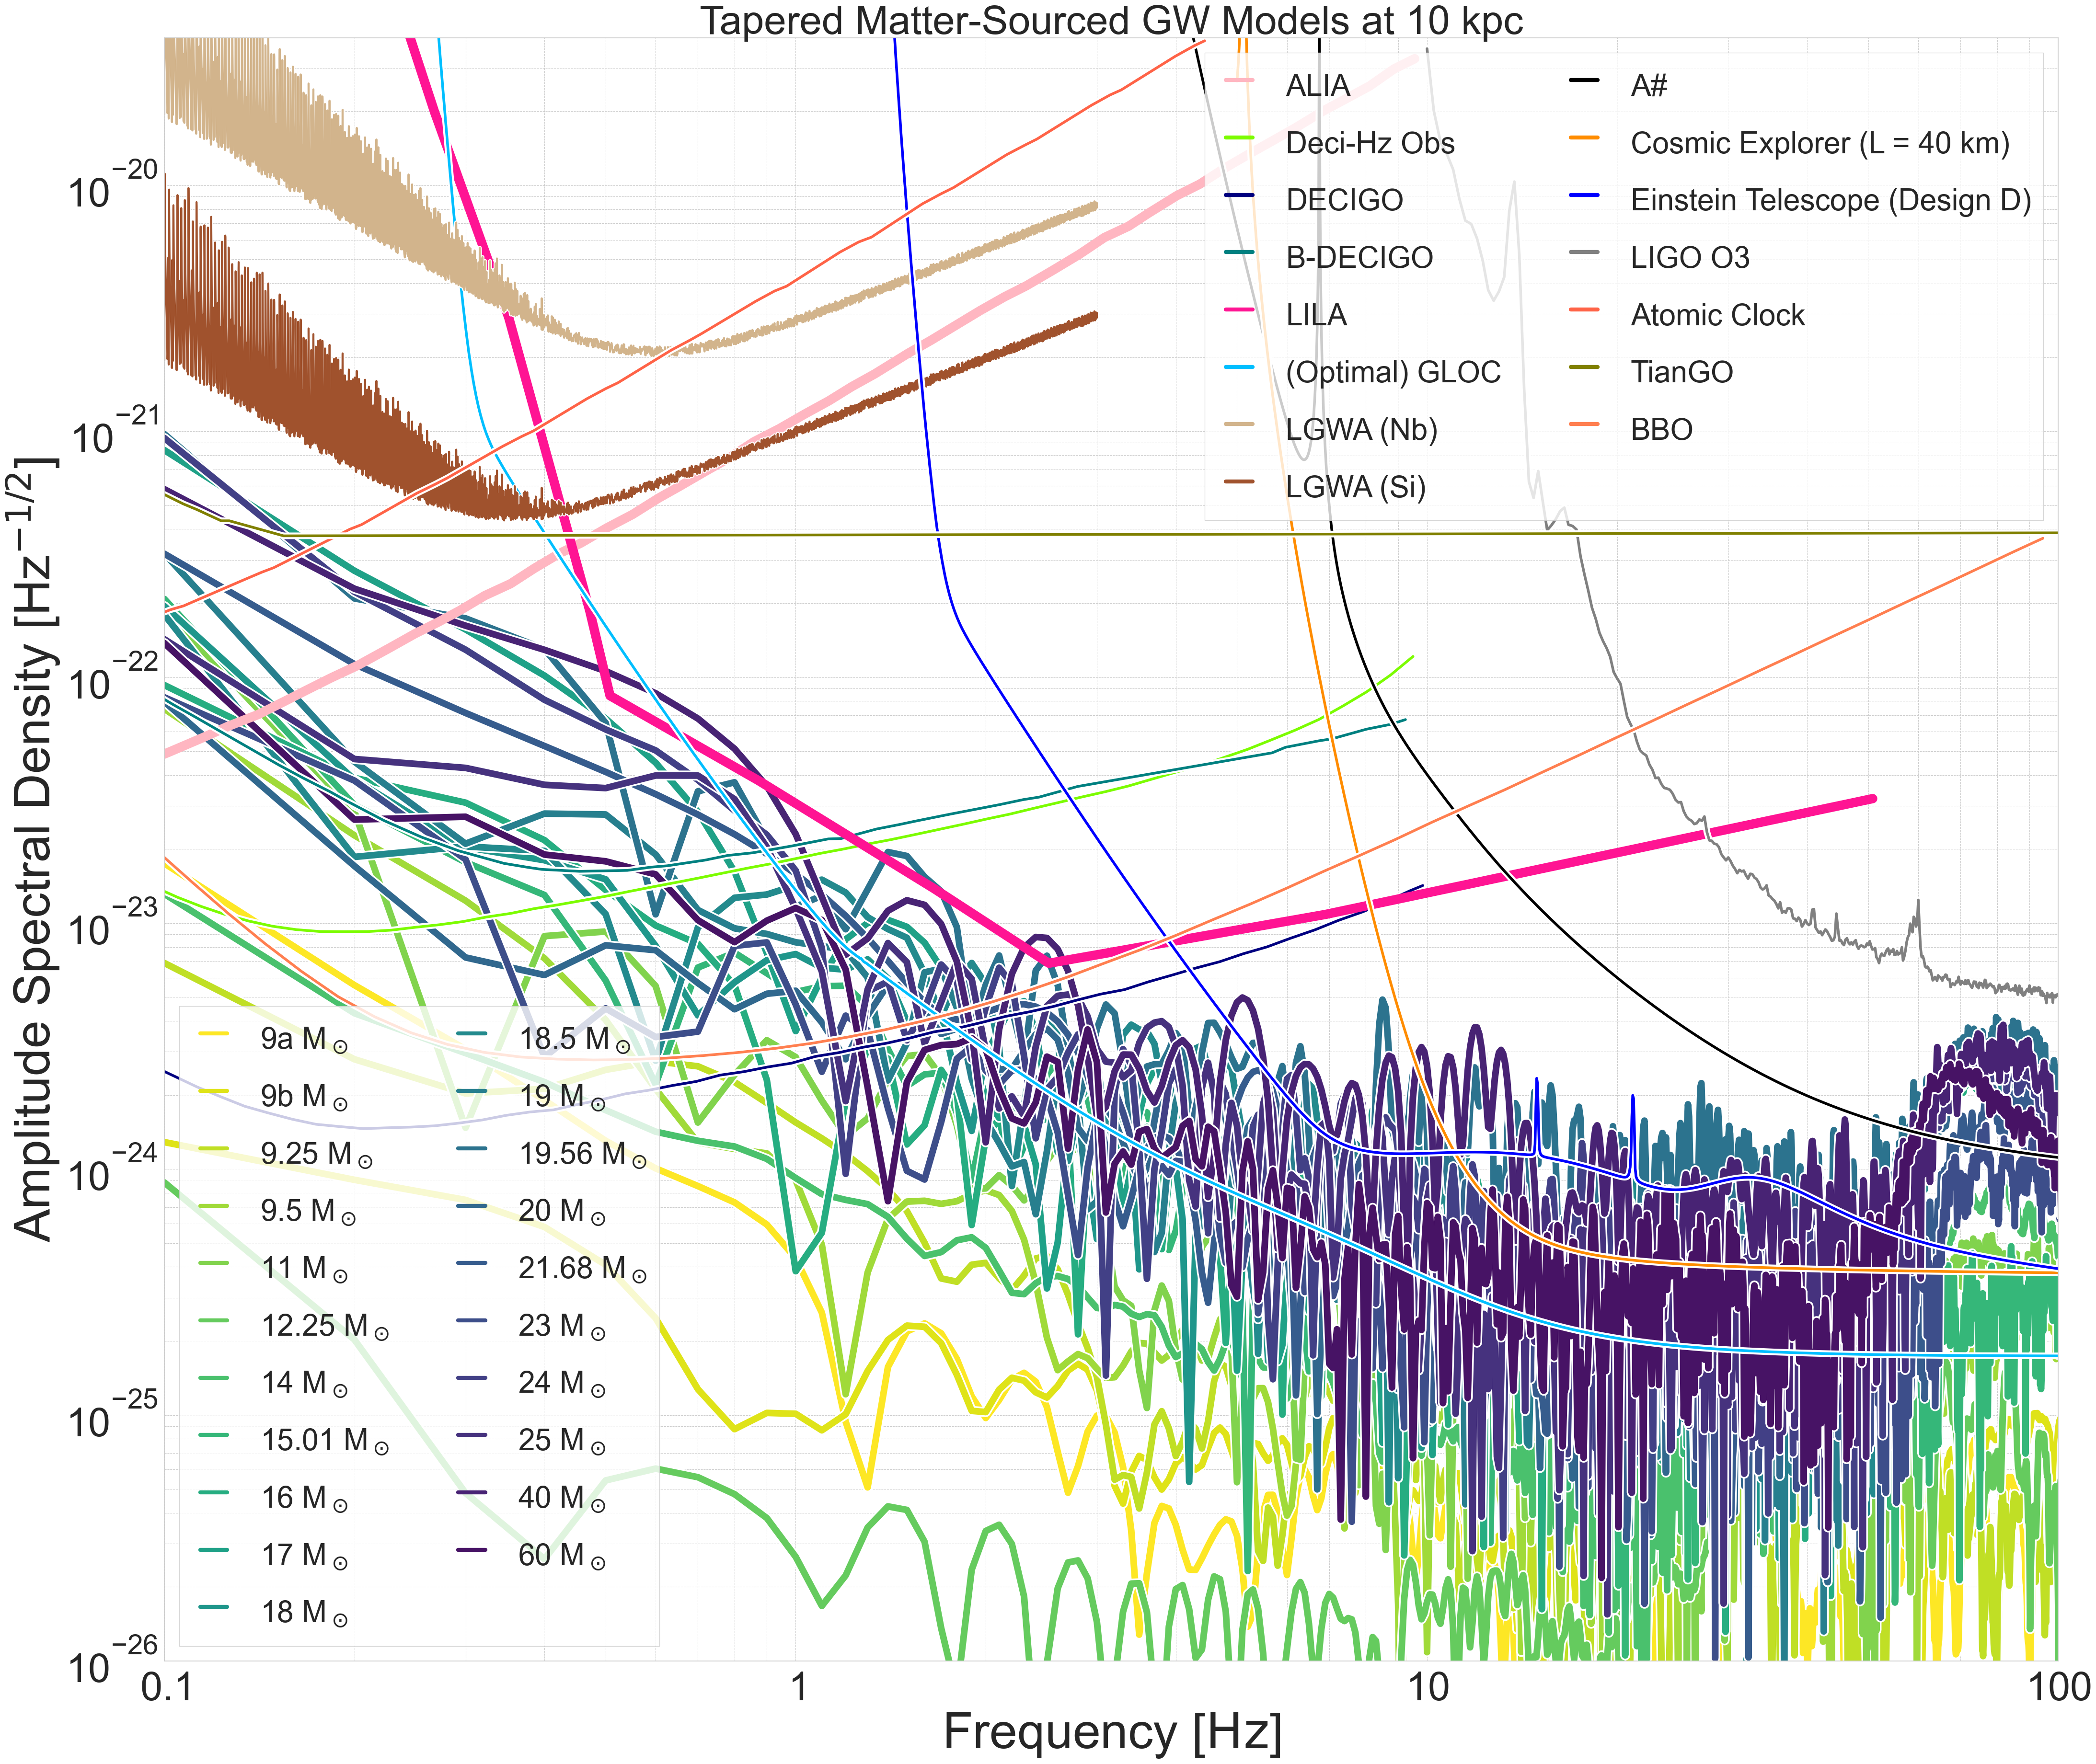

In [5]:
models = ['9a', '9b', '9.25', '9.5', '11', '12.25', '14', '15.01', '16', '17', '18', '18.5', '19', '19.56', '20', '21.68', '23', '24', '25', '40', '60']
fig, ax = plt.subplots(figsize=(51, 44))
final_curves = plot_waveforms(models,*model_list(final_models_matter,var1='freq', var2='psd'), ax, cmap=plt.cm.viridis_r)
sensitivity_curves = plot_sensitivity_curves(ax)
style_plot(ax, legends = [sensitivity_curves, final_curves])
ax.set_title('Tapered Matter-Sourced GW Models at 10 kpc', fontsize=60)
plt.show()